In [26]:
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from pytorch_tabnet.tab_model import TabNetClassifier

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# import data
df = pd.read_csv("./data/CEE_DATA.csv", quotechar="'")

X = df[
    [
        "Gender",
        "Caste",
        "coaching",
        "time",
        "Class_ten_education",
        "twelve_education",
        "medium",
        "Class_X_Percentage",
        "Class_XII_Percentage",
        "Father_occupation",
        "Mother_occupation",
    ]
]
Y = df["Performance"]

In [20]:
# split data
seed = 1
# X_rem, X_test, Y_rem, Y_test = train_test_split(
#     X, Y, test_size=0.2, random_state=seed
# )
# X_train, X_val, Y_train, Y_val = train_test_split(
#     X_rem, Y_rem, test_size=0.2, random_state=seed
# )
# print("Train Size Instances: ", X_train.shape[0])
# print("Test Size Instances:", X_test.shape[0])
# print("Validation Size Instances:", X_val.shape[0])


In [21]:
ohe = OneHotEncoder(sparse=False)
Xcoded = pd.DataFrame(ohe.fit_transform(X),columns=ohe.get_feature_names(['Gender', 'Caste', 'coaching', 'time', 'Class_ten_education',
       'twelve_education', 'medium', 'Class_X_Percentage',
       'Class_XII_Percentage', 'Father_occupation', 'Mother_occupation']))
X_rem_enc, X_test_enc, Y_rem_enc, Y_test_enc = train_test_split(
    Xcoded, Y, test_size=0.2, random_state=seed
)
X_train_enc, X_val_enc, Y_train_enc, Y_val_enc = train_test_split(
    X_rem_enc, Y_rem_enc, test_size=0.2, random_state=seed
)
print("Train Size Instances: ", X_train_enc.shape[0])
print("Test Size Instances:", X_test_enc.shape[0])
print("Validation Size Instances:", X_val_enc.shape[0])

Train Size Instances:  425
Test Size Instances: 134
Validation Size Instances: 107


## TabNet

In [23]:
clf = TabNetClassifier()

max_epochs = 1000 if not os.getenv("CI", False) else 2

# clf.fit(
#   X_train_enc.to_numpy(), Y_train_enc,
#   eval_set=[(X_val_enc.to_numpy(), Y_val_enc)]
# )

clf.fit(
    X_train=X_train_enc.to_numpy(), y_train=Y_train_enc,
    eval_set=[(X_train_enc.to_numpy(), Y_train_enc), (X_val_enc.to_numpy(), Y_val_enc)],
    eval_name=['train', 'valid'],
    # eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

# preds = clf.predict(X_test_enc.to_numpy())

Device used : cpu
epoch 0  | loss: 1.70816 | train_accuracy: 0.28941 | valid_accuracy: 0.34579 |  0:00:00s
epoch 1  | loss: 1.56507 | train_accuracy: 0.31059 | valid_accuracy: 0.28037 |  0:00:00s
epoch 2  | loss: 1.55495 | train_accuracy: 0.32706 | valid_accuracy: 0.3271  |  0:00:00s
epoch 3  | loss: 1.40722 | train_accuracy: 0.30353 | valid_accuracy: 0.26168 |  0:00:00s
epoch 4  | loss: 1.43095 | train_accuracy: 0.32    | valid_accuracy: 0.27103 |  0:00:00s
epoch 5  | loss: 1.41079 | train_accuracy: 0.31059 | valid_accuracy: 0.33645 |  0:00:00s
epoch 6  | loss: 1.42844 | train_accuracy: 0.33882 | valid_accuracy: 0.35514 |  0:00:00s
epoch 7  | loss: 1.34289 | train_accuracy: 0.33647 | valid_accuracy: 0.37383 |  0:00:00s
epoch 8  | loss: 1.34597 | train_accuracy: 0.33882 | valid_accuracy: 0.37383 |  0:00:00s
epoch 9  | loss: 1.30226 | train_accuracy: 0.35529 | valid_accuracy: 0.3271  |  0:00:00s
epoch 10 | loss: 1.29858 | train_accuracy: 0.34588 | valid_accuracy: 0.35514 |  0:00:01s
epo

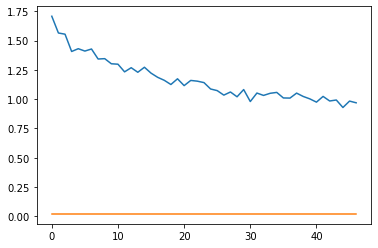

In [30]:
# plot losses
plt.plot(clf.history['loss'])

# plot auc
# plt.plot(clf.history['train_auc'])
# plt.plot(clf.history['valid_auc'])

# plot learning rates
plt.plot(clf.history['lr'])


## Global explainability : feat importance summing to 1

In [36]:
clf.feature_importances_

array([8.94109829e-02, 2.90647621e-03, 3.02921656e-01, 3.39317431e-05,
       2.53313252e-03, 2.87156130e-01, 5.94736534e-02, 3.66799770e-03,
       6.68928611e-03, 4.93215851e-03, 1.04012416e-03, 1.81807249e-03,
       0.00000000e+00, 4.33520414e-05, 4.90531646e-04, 1.57044295e-03,
       2.66362488e-03, 2.55876063e-03, 1.71952246e-04, 1.09411011e-02,
       2.58687346e-03, 7.86765389e-03, 1.26611517e-02, 1.40420799e-03,
       1.25283932e-03, 1.49743494e-02, 1.34909904e-02, 5.14109381e-03,
       5.18679004e-04, 2.43902944e-03, 1.15197755e-02, 2.51676796e-02,
       1.91053756e-03, 4.56113301e-03, 4.18225462e-02, 6.48798897e-06,
       6.64295609e-03, 4.07905174e-04, 2.64176165e-04, 1.63158120e-03,
       1.20738363e-03, 2.11990055e-03, 0.00000000e+00, 1.54040773e-03,
       4.02915611e-03, 1.12639978e-03, 5.22124131e-02, 4.53903715e-04,
       1.54212484e-05])

## Local explainability and masks

In [33]:
explain_matrix, masks = clf.explain(X_test_enc.to_numpy())